# Supplementary Materials of AIR-CDR simulation plots

This file shows how simulation was performed to draw AIR-CDR plots for different prevalence of csPCa and diagnostic performances of prostate MRI.

### Abbreviations
- aCDR = cancer detection rate adjusted for pathological confirmation rate
- csPCa = clinically significant prostate cancer
- AIR = abnodmal interpretation rate
- AUROC = area under the receiver operating characteristic curve
- CDR = cancer detection rate
- ROC curve = receiver operating characteristic curve
- SD = standard deviation

### (Settings for drawing plots)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from itertools import product
plt.rcParams.update({"font.size":10})
color_list = sns.color_palette("colorblind").as_hex()

In [2]:
# Align Markdown formulas and tables to the left

In [3]:
%%html
<style>
    table{float:left}
    .MathJax{float: left;}
</style>

## 1. Definition of CDR and AIR

The simulation data assumed a pathological confirmation rate of 100%. This is the main difference between the simulation and the clinical data. (The CDR in the simulation could be considered analogous to the aCDR in the clinical data.) First, define some performance metrics using a 2x2 confusion matrix that represent the counts of prediction value in rows and actual value in columns.

|             |csPCa (+)|csPCa (-)|
|-------------|-------------|-------------|
|Exam positive|A|B| 
|Exam negitive|C|D| 

### 1-1. Basic performance metrics and disease prevalence

Base on the confusion matrix, we first calculated the sensitivity, specificity, and prevalence of csPCa.

$$
\begin{aligned}
    Sensitivity &= \frac{A}{A+C}
\end{aligned}
$$

$$
\begin{aligned}
    Specificity &= \frac{D}{B+D}
\end{aligned}
$$

$$
\begin{aligned}
    Prevalence &= \frac{A+C}{A+B+C+D}
\end{aligned}
$$

### 1-2. CDR and AIR

Next, we calculated CDR and AIR as follows:

$$
\begin{align}
    CDR &= \frac{A}{A+B+C+D}\\
    　　 &=Sensitivity \times Prevalence\\
\end{align}
$$

$$
\begin{align}
    AIR &= \frac{A+B}{A+B+C+D}\\
        &= CDR + \frac{B}{A+B+C+D}\\
        &= CDR + \frac{B}{B+D} \times \frac{B+D}{A+B+C+D}\\
        &= CDR + (1-Specificity) \times (1-Prevalence)\\
\end{align}
$$

## 2. Simulation plots of AIR and CDR
A binormal model, frequently used in the receiver operating characteristic (ROC) curve, was used. The model assumes a set of scores that are normally distributed for each population (with and without csPCa). The distance between the two distributions reflects the diagnostic performance. First, sensitivity and specificity were calculated by varying the threshold scores, which is same as constructing ROC curve. Next, we varied the prevalence and the distance between the two distributions. We calculated and used the area under the ROC curve (AUROC) as a more familiar metric of diagnostic performance than the "distance". The AIR and CDR were calculated using the above formula.

In [15]:
# define fuction to draw simulation plots
def create_plots(distance, prev, ax=None, ax_row=None, plot=True, ret=False):
    sns.set_palette("colorblind")
    """
    1. Create binormal model of the exams scores having distance of "distance", SD of 1, and prevalence of "prev" 
    2. Calculate some metrics on the binormal model including sensitivity, specificity, AUROC, CDR, and AIR
    ----------
    Parameters
    ----------
    distance : float
        The name of the animal
    prev : float (0 to 1)
        Disease prevalence of clinically significant prostate cancer
    ax : matplotlib Axes object
    ax_row: int
        number of row to show plots in the ax object
    plot: bool
        if True, create four plots on different columns
        1. Binormal distribution of exam scores
        2. Sensitivity and specificity
        3. ROC curve
        4. CDR and AIR
    ret: bool
        if True, return dictionary containing each score level sensitivity, specificity, AUROC, CDR, and AIR
    """
    ### Define variavbles for simulation plots ###
    # 1. mean score of the disease group (csPCa +) and control group
    mean_score_d = distance/2
    mean_score_c = -distance/2
    # 2. number of sampling scores
    n_score = 500
    # 3. limit of the score
    score_limit = 5
    # 4. parameters of the scatter plots (color and size)
    c1 = -4
    c2 = -3
    s = 50
    
    ### Prepare multiple scores between "-score_limit" to "score_limit" (n=n_score) ###
    score = np.linspace(-score_limit, score_limit, n_score)
    # add -inf, and inf in the score (for AUROC calculation)
    score = np.hstack([-np.inf, score, np.inf])
    
    ### calculate sensitivity and specificity for each exam score ###
    sens = 1-norm.cdf(score, loc = mean_score_d)
    spec = norm.cdf(score, loc = mean_score_c)
    
    ### calculate CDR and AIR using prevalence ###
    CDR = sens * prev
    AIR = CDR + (1-spec) * (1-prev)
    
    ### calculate AUROC by summing up partial AUROC ###
    AUROC = 0
    for score_index in range(0, n_score+1):
        # mean sensitivity between score[score_index] and score[score_index+1]
        mean_sens = (sens[score_index] + sens[score_index+1])/2
        # difference in specificity between score[score_index] and score[score_index+1]
        dif_spec = (spec[score_index+1] - spec[score_index])
        partial_AUROC = mean_sens * dif_spec
        AUROC += partial_AUROC
    
    ### Simulation plot ###
    if plot:
        ## 1. score distribution on disease group and control group
        dist_c = norm.pdf(score, loc = mean_score_c)*(1-prev)*100
        dist_d = norm.pdf(score, loc = mean_score_d)*prev*100
        ax[ax_row, 0].plot(score, dist_c, label="csPCa (-)", lw=2)
        ax[ax_row, 0].plot(score, dist_d, label="csPCa (+)", lw=2)
        ax[ax_row, 0].scatter(-score_limit+0.2,0, color=color_list[c2], s=s)
        ax[ax_row, 0].scatter(score_limit-0.2,0, color=color_list[c1], s=s)
        ax[ax_row, 0].set_title(f"Patient distribution on exam score\n(a distance of {distance} SD and a prevalence of {prev})")
        ax[ax_row, 0].set_xlabel("Exam score (SD)")
        ax[ax_row, 0].set_ylabel("Percentage in the population (%)")
        ax[ax_row, 0].vlines(x=mean_score_d, ymin=0, ymax=np.max(dist_d), colors='black', ls='--', lw=0.5)
        ax[ax_row, 0].vlines(x=mean_score_c, ymin=0, ymax=np.max(dist_c), colors='black', ls='--', lw=0.5)
        ax[ax_row, 0].set_xlim((-score_limit, score_limit))
        ax[ax_row, 0].annotate('', xy=[mean_score_c, 0], xytext=[mean_score_d, 0], arrowprops=dict(arrowstyle='<->'))
        ax[ax_row, 0].text(0, 1, f"{distance}", ha="center")
        ax[ax_row, 0].legend(loc = "upper right")

        ## 2. Sensitivity and specificity
        ax[ax_row, 1].plot(score, spec, label="Specificity", lw=2)
        ax[ax_row, 1].plot(score, sens, label="Sensitivity", lw=2)
        ax[ax_row, 1].scatter(-score_limit+0.2,0, color=color_list[c2], s=s)
        ax[ax_row, 1].scatter(score_limit-0.2,0, color=color_list[c1], s=s)
        ax[ax_row, 1].scatter(-score_limit+0.2,1, color=color_list[c2], s=s)
        ax[ax_row, 1].scatter(score_limit-0.2,1, color=color_list[c1], s=s)
        ax[ax_row, 1].set_title(f"Sensitivity and Specificity\n(a distance of {distance} SD)")
        ax[ax_row, 1].set_xlabel("Exam score (SD)")
        ax[ax_row, 1].set_ylabel("Metrics score")
        ax[ax_row, 1].set_xlim((-score_limit, score_limit))
        ax[ax_row, 1].legend(bbox_to_anchor=(1, 0.7), loc="center right")

        ## 3. ROC curve
        ax[ax_row, 2].plot(1-spec, sens, label=f"AUROC:{round(AUROC, 2)}", c=color_list[2], lw=2)
        x = np.linspace(0,1,n_score)
        ax[ax_row, 2].plot(x, x, label=f"Sensivity = 1- Specificity", ls='--', lw=1,  c="#7f7f7f")
        ax[ax_row, 2].scatter(0,0, color=color_list[c1], s=s)
        ax[ax_row, 2].scatter(1,1, color=color_list[c2], s=s)
        ax[ax_row, 2].set_title(f"ROC curve\n(a distance of {distance} SD)")
        ax[ax_row, 2].set_xlabel("1 - Specificity")
        ax[ax_row, 2].set_ylabel("Sensitivity")
        ax[ax_row, 2].set_xlim((-0.05, 1.05))
        ax[ax_row, 2].set_ylim((-0.05, 1.05))
        ax[ax_row, 2].legend(bbox_to_anchor=(1, 0.1),loc="center right")

        ## 4. AIR/CDR plot
        ax[ax_row, 3].plot(AIR, CDR, label=f"AUROC:{round(AUROC, 2)}", color=color_list[4], lw=2)
        ax[ax_row, 3].set_title(f"AIR and CDR\n(a distance of {distance} SD and a prevalence of {prev})")
        ax[ax_row, 3].set_xlabel("AIR")
        ax[ax_row, 3].set_ylabel("CDR")
        ax[ax_row, 3].scatter(0,0, color=color_list[c1], s=s)
        ax[ax_row, 3].scatter(1,prev, color=color_list[c2], s=s)
        ax[ax_row, 3].set_xlim((-0.05, 1.05))
        ax[ax_row, 3].set_ylim((-0.05, 1.05))
        ax[ax_row, 3].hlines(y=prev, xmin=-0.05, xmax=1, color=color_list[3], ls=':', lw=1, label=f'CDR = prevalence')
        ax[ax_row, 3].plot(x, x, label=f"CDR = AIR", ls='--', lw=1,  c="#7f7f7f")
        ax[ax_row, 3].legend(bbox_to_anchor=(1, 0.1), loc="center right")
    if ret:
        return {"score":score, "sens":sens, "spec":spec, "AUROC":AUROC, "CDR":CDR, "AIR":AIR}

## Flow of creating AIR-CDR simulation plots

### Columns
Each column represents the different metrics with a fixed diagnostic performance and prevalence.
1. Binormal distribution of the patients with and without csPCa
    - The greater the distance between the two distributions, the better the classification.
2. Sensitivity and specificity on each exams scores 
3. ROC curve
4. CDR and AIR (created from sensitivity, specificity, and prevalence)

### Rows
Each row represenst a population with a specific diagnostic performance and prevalence.
1. Better diagnostic performance (mean distance = 2.5 SD), high disease prevalence (0.5)
2. Worse diagnostic performance (mean distance = 0.5 SD), high disease prevalence (0.5)
3. Better diagnostic performance (mean distance = 2.5 SD), low disease prevalence (0.2)

The pink and gray scatter plots represent the corresponding positional relationship among columns. (Independent for each row.)

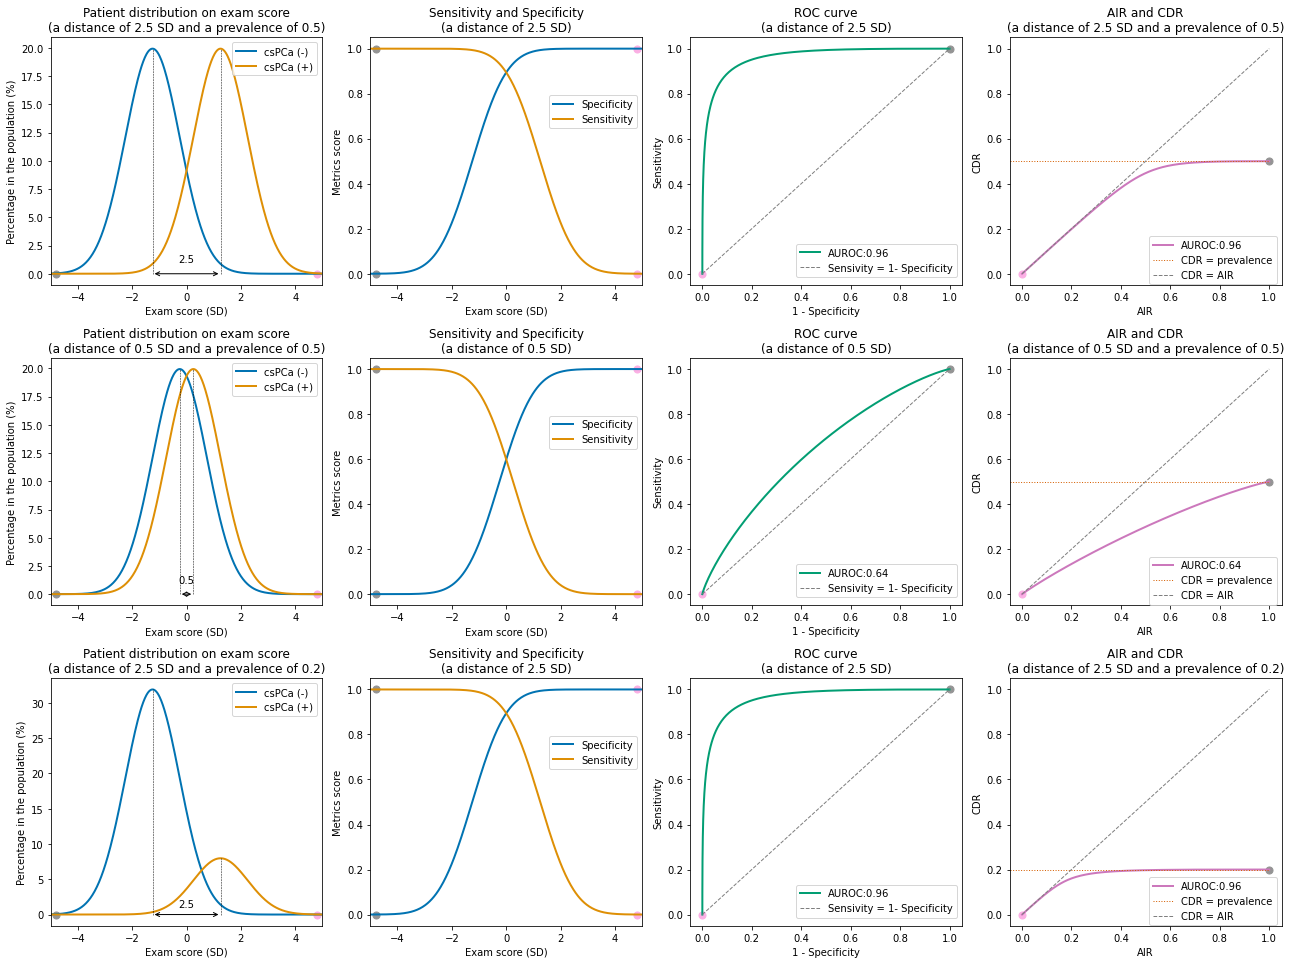

In [16]:
nrows = 3
fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(18, 4.5*nrows))
create_plots(distance=2.5, prev=0.5, ax=ax, ax_row=0)
create_plots(distance=0.5, prev=0.5, ax=ax, ax_row=1)
create_plots(distance=2.5, prev=0.2, ax=ax, ax_row=2)
plt.tight_layout()

The AIR-CDR plots could be considered analogous to the ROC curve in reflecting diagnostic performance with different thresholds. The difference is AIR-CDR plots are affected by prevalence. The AIR-CDR plot starts at an AIR of 0% with a CDR of 0%. It ends at AIR of 100% with CDR at disease prevalence, having an assumption of a 100% pathological confirmation rate. As AIR increases, so does CDR, but CDR is always less than or equal to AIR.

## 3. The effect of diagnostic performance and prevalence on AIR/CDR plots

The AIR-CDR simulation line is affected by both diagnostic performance and disease prevalence. We will visualize each effects on a single image. First, prepare multiple combinations of distance between the binormal distribution and prevalence. Next, calculate the metrics for each.
- distance: 100 samples (0.05 to 2.5)
- prevalence: 3 samples (0.3, 0.4, 0.5)

In [6]:
distances = np.linspace(0.05, 2.5, 100)
prevs = np.linspace(0.3, 0.5, 3)
df = pd.DataFrame(product(distances, prevs))
df.columns = ["distance", "prevalence"]
df = df.sort_values(["distance", "prevalence"])

# extract metrics values on the mean distance and prevalence
results = df.apply(lambda row: create_plots(row["distance"], row["prevalence"], plot=False, ret=True), axis=1).apply(pd.Series)
results = pd.concat([df, results], axis=1)

*results* DataFrame contains the metrics on each distance and prevalence

In [7]:
# show examples
results.head(6)

,distance,prevalence,score,sens,spec,AUROC,CDR,AIR
0,0.050000,0.3,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997482837318, 0.999999720631723, 0...","[0.0, 3.262381995583942e-07, 3.617260013380173...",0.514101,"[0.3, 0.29999992448511953, 0.2999999161895169,...","[1.0, 0.9999996961183797, 0.9999996629813159, ..."
1,0.050000,0.4,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997482837318, 0.999999720631723, 0...","[0.0, 3.262381995583942e-07, 3.617260013380173...",0.514101,"[0.4, 0.3999998993134928, 0.39999988825268923,...","[1.0, 0.999999703570573, 0.9999996712170884, 0..."
2,0.050000,0.5,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997482837318, 0.999999720631723, 0...","[0.0, 3.262381995583942e-07, 3.617260013380173...",0.514101,"[0.5, 0.4999998741418659, 0.4999998603158615, ...","[1.0, 0.9999997110227661, 0.9999996794528608, ..."
3,0.074747,0.3,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997640186564, 0.9999997380323467, ...","[0.0, 3.477316326504121e-07, 3.854650376302989...",0.521075,"[0.3, 0.2999999292055969, 0.299999921409704, 0...","[1.0, 0.9999996857934541, 0.9999996515841776, ..."
4,0.074747,0.4,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997640186564, 0.9999997380323467, ...","[0.0, 3.477316326504121e-07, 3.854650376302989...",0.521075,"[0.4, 0.39999990560746257, 0.39999989521293866...","[1.0, 0.999999696968483, 0.999999663933916, 0...."
5,0.074747,0.5,"[-inf, -5.0, -4.979959919839679, -4.9599198396...","[1.0, 0.9999997640186564, 0.9999997380323467, ...","[0.0, 3.477316326504121e-07, 3.854650376302989...",0.521075,"[0.5, 0.4999998820093282, 0.4999998690161733, ...","[1.0, 0.9999997081435119, 0.9999996762836545, ..."


We used AUROC as a diagnostic performance metric because it is more familiar than distance of the binormal distribution. We defined function to extract AUROC close to target value.

In [14]:
def getNearest_index(ds, num):
    # Calculate the difference between the element and the target value and get the index of the minimum value
    idx = np.abs(ds - num).argmin()
    return idx

### 3-1 With a fixed prevalence of 0.4, vary the AUROC from 0.50 to 0.95

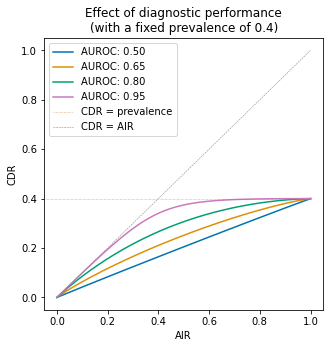

In [9]:
plt.figure(figsize=(5,5))
# AIR/CDR plots in AUROC of 0.5, 0.65, 0.8, and 0.95
for i, AUROC in enumerate([0.50, 0.65, 0.80, 0.95]):
    ind_closeAUROC = getNearest_index(results["AUROC"], AUROC)
    # prevelence = 0.4 -> ind_closeAUROC+1
    ds_closeAUROC = results.loc[ind_closeAUROC+1]
    # define color
    if not i==3:
        color=color_list[i]
    else:
        color=color_list[4]
    plt.plot(ds_closeAUROC["AIR"], ds_closeAUROC["CDR"], label=f"AUROC: {AUROC:.2f}", color=color)
    plt.ylim((-0.05, 1.05))
    plt.xlim((-0.05, 1.05))
    
x = np.linspace(0,1,1000)
plt.hlines(y=0.4, xmin=-0.05, xmax=1, colors=color_list[3], ls=':', lw=0.5, label=f'CDR = prevalence')
plt.plot(x, x, label=f"CDR = AIR", ls='--', lw=0.5,  c="#7f7f7f")
plt.title("Effect of diagnostic performance\n(with a fixed prevalence of 0.4)")
plt.xlabel("AIR")
plt.ylabel("CDR")
plt.legend()

With higher diagnostic performance, the line becomes convex with the apex toward the upper left corner.

### 3-2 With a fixed diagnostic performance (AUROC of 0.8), vary the prevalence from 0.3 to 0.5

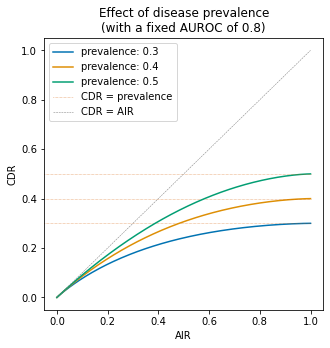

In [12]:
AUROC = 0.8
ind_closeAUROC = getNearest_index(results["AUROC"], AUROC)
plt.figure(figsize=(5,5))

# AIR/CDR plots in prevalence of 0.3, 0.4, and 0.5
for ind in range(ind_closeAUROC, ind_closeAUROC+3):
    ds_closeAUROC = results.loc[ind]
    plt.plot(ds_closeAUROC["AIR"], ds_closeAUROC["CDR"], label=f"prevalence: {ds_closeAUROC['prevalence']}")
    plt.ylim((-0.05, 1.05))
    plt.xlim((-0.05, 1.05))
    if ind == ind_closeAUROC+2:
        label = "CDR = prevalence"
    else:
        label = None
    plt.hlines(y=ds_closeAUROC['prevalence'], xmin=-0.05, xmax=1, colors=color_list[3], ls=':', lw=0.5, label = label)
    
plt.plot(x, x, label=f"CDR = AIR", ls='--', lw=0.5,  c="#7f7f7f")
plt.title("Effect of disease prevalence\n(with a fixed AUROC of 0.8)")
plt.xlabel("AIR")
plt.ylabel("CDR")
plt.legend()

With a fixed diagnostic performance, the higher disease prevalence shifts the line upward. 